In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Impotando os dados da quantidade de passageiros por mês em uma linha aérea. Como séries temporais utiliza o index como base, iremos importar os dados colocando os meses como index e deixando eles em forma de data(datetime).

In [2]:
#Leitura dos dados
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month')

In [3]:
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
data.dtypes

#Passengers    int64
dtype: object

Text(0.5, 0, 'Data - mensal')

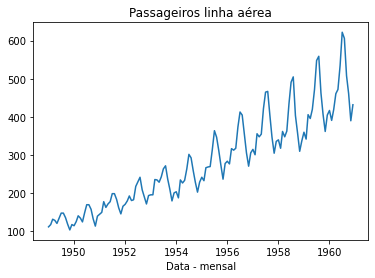

In [5]:
plt.plot(data)
plt.title('Passageiros linha aérea')
plt.xlabel('Data - mensal')

Aparentemente, temos o gráfico de uma série temporal com tendência crescente e sazonalidade bem definida. Vamos então fazer a decomposição dos dados.

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

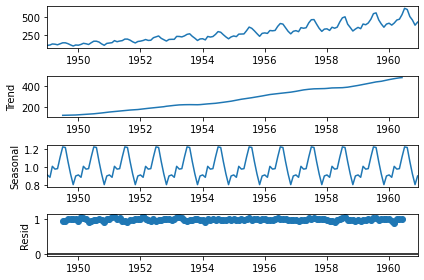

In [7]:
resultado = seasonal_decompose(data, model='multiplicative')
resultado.plot()
plt.show()

A partir da decomposição da série temos que os dados tem uma tendência crescente e positiva (Tred), uma sazonalidade bem definida (Seasonal) e no gráfico de erros não tem um padrão de tendência e nem sazonalidade. Erro sem padrão indica que foi extraído os dados significativos.

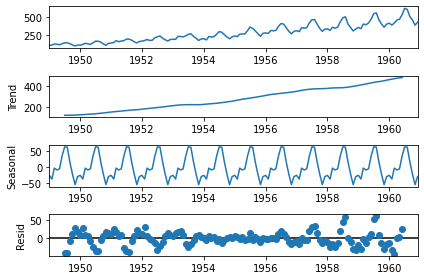

In [8]:
resultado = seasonal_decompose(data, model='aditive')
resultado.plot()
plt.show()

Utilizando o modelo aditivo temos resultados parecidos mas em escalas diferentes, contudo, os resíduos contínuam sem um padrão definido.

### Verificando estacionaridade

p <= 0,05 : Série temporal estacionária

In [9]:
# Teste Dick-Fuller
from statsmodels.tsa.stattools import adfuller

In [10]:
y = data['#Passengers']

In [11]:
t_estacionario = adfuller(y)

In [12]:
t_estacionario

(0.8153688792060482,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

Esse teste imprime vários resultados, mas o que a gente está interessado é no valor p. O valor p é o segundo valor.

In [13]:
print('Valor p: %f'%t_estacionario[1])

Valor p: 0.991880


Valor p > 0,05 indica que a série não é estacionária.

Tem algumas manipulações que só podem ser realizadas se os dados forem uma série temporal. Portanto, iremos fazer uma diferenciação nos dados (valor atual - valor anterior).

In [14]:
y_diff = np.diff(y)

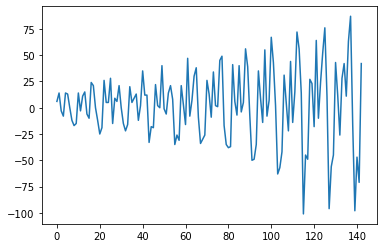

In [15]:
plt.plot(y_diff)

Com apenas uma diferenciação já podems perceber que a média dos pontos dos quadrados estão quase contantes. Para fazer a prova, iremos calcular o valor p novamente.

In [16]:
t_diff = adfuller(y_diff)
t_diff

(-2.8292668241699994,
 0.0542132902838255,
 12,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 988.5069317854084)

Para esse novo teste o valor p está no limiar para o modelo ser estacionário. Vamos fazer novamente uma diferenciação.

In [17]:
y_diff2 = np.diff(y_diff)

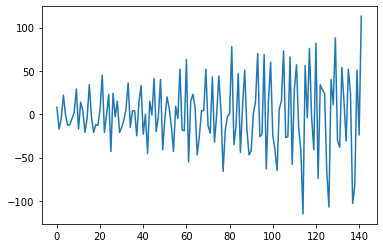

In [18]:
plt.plot(y_diff2)

In [19]:
t_diff2 = adfuller(y_diff2)
t_diff2

(-16.384231542468505,
 2.7328918500142407e-29,
 11,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 988.60204172756)

Analisando esse gráfico e o valor p verificamos que o modelo do y_diff2 é estacionário. Precisou de duas diferenciações do modelo principal.

### Previsões

Iremos fazer a previsão do número de passageiros para os próximos meses da série. Iremos utilizar a tendência exponencial simples, a exponencial amortecida (Holt Winters) e a linear de Holt 

In [20]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

#### Tendência exponencial simples

In [21]:
# Utilizando a tendência exponencial simples
fit1 = SimpleExpSmoothing(data).fit(smoothing_level=0.2, optimized=False)
fcast1 = fit1.forecast(12).rename(r'$\alpha=0.2$')

C:\Users\Marcela\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<AxesSubplot:xlabel='Month'>

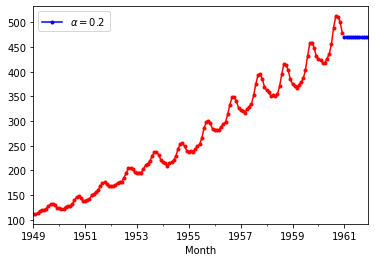

In [22]:
fcast1.plot(marker='.', color='blue', legend=True)
fit1.fittedvalues.plot(marker='.',  color='red')

Essa previsão(forecast - 12 meses) faz o cálculo da média e coloca pesos nos meses ($\alpha$). Não é muito adequado para gráficos com tendências.

#### Tendência Linear de Holt

In [23]:
# Tendência Linear de Holt
fit2 = Holt(data).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized = False)
fcast2 = fit2.forecast(12).rename('Holts linear trend')

C:\Users\Marcela\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-23-cb3106804805>:2: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit2 = Holt(data).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized = False)


<AxesSubplot:xlabel='Month'>

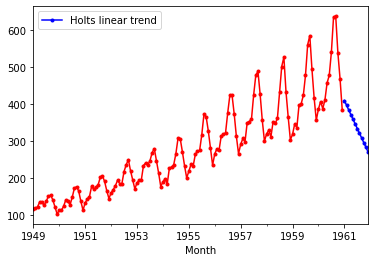

In [24]:
fcast2.plot(marker='.', color='blue', legend=True)
fit2.fittedvalues.plot(marker='.',  color='red')

O smoothing_level é o peso para os dados e varia entre 0 e 1. Quando mais próximo de 0, os dados mais antigos tem maior peso. Já quanto mais próximo de 1, os dados mais novos tem mais peso.

Quando o smoothing_level fica próximo de 1 ele criou uma previsão de queda do modelo pois ele definiu peso maior para os últimos dados que, nesse caso, estão em queda. 

#### Tendência Linear de Holt Amortecida

In [25]:
# Tendência Linear de Holt Amortecida
fit3 = Holt(data, damped=True).fit(smoothing_level=0.5, smoothing_slope=0.8)
fcast3 = fit2.forecast(12).rename("Additive damped trend")

<ipython-input-25-368f7290954c>:2: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  fit3 = Holt(data, damped=True).fit(smoothing_level=0.5, smoothing_slope=0.8)
C:\Users\Marcela\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-25-368f7290954c>:2: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit3 = Holt(data, damped=True).fit(smoothing_level=0.5, smoothing_slope=0.8)


<AxesSubplot:xlabel='Month'>

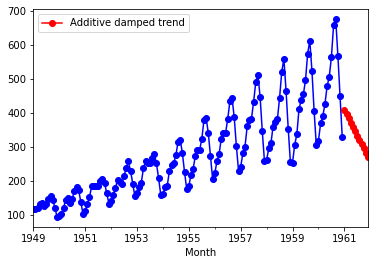

In [26]:
fit3.fittedvalues.plot(marker="o", color='blue')
fcast3.plot(color='red', marker="o", legend=True)

Testando o modelo amortecido também não obtivemos resultados muito adequados os dados.

Essa previsão linar não teve uma boa performance nos dados do problema.

#### Tendência Exponencial Amortecida

In [27]:
# Tendência Exponencial Amortecida
fit4 = ExponentialSmoothing(data,seasonal_periods=60,trend="mul",seasonal="mul",use_boxcox=True,initialization_method="estimated",
).fit()
fcast4 = fit4.forecast(24).rename("Exponencial Holt")

C:\Users\Marcela\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Marcela\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


<AxesSubplot:>

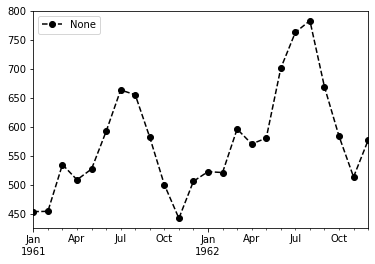

In [28]:
# Previsão
fit4.forecast(24).plot(style='--', marker='o', color='black', legend=True)

<AxesSubplot:xlabel='Month'>

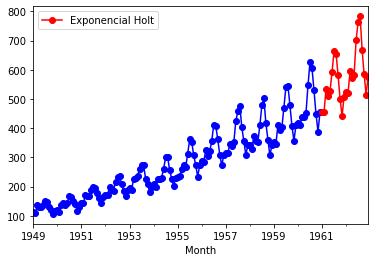

In [29]:
fit4.fittedvalues.plot(marker="o", color='blue')
fcast4.plot(color='red', marker="o", legend=True)

A tendência de Holt Winters Sazonal (Exponencial amortecida) é a que melhor se adequa aos dados pois ela inclui a captura da sazonalidade e também da tendência.

No gráfico acima observa-se que o comportamento previsto é bem semalhente ao comportamento existente dos dados, seguindo tendência crescente positiva e sazonalidade definida.

#### ARIMA

Para esse modelo teremos que verificar as autocorrelações por meio dos diagramas de ACF e PACF e também o número de diferenciações realizadas para tornar o modelo estacionário.

AR - Autoregressivo (p - número de picos PACF)

I - Tntegrated (d - diferenciações)

MA - Moving Average (q - número de picos ACF)

Lembrando que quanto menor for os valores de AIC e BIC, melhor o modelo

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

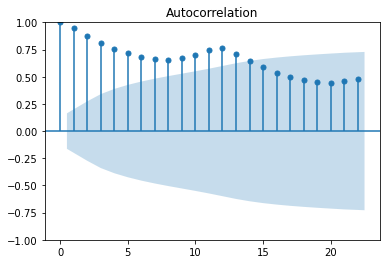

In [31]:
plot_acf(data)
plt.show()
#Número de picos acima do intervalo de confiança (q): 14 (aproximadamente)

C:\Users\Marcela\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


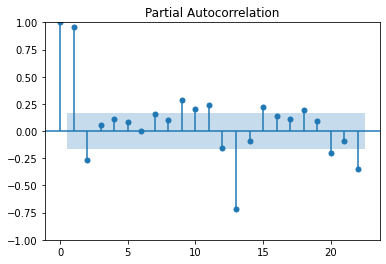

In [32]:
plot_pacf(data)
plt.show()
#Número de picos acima do intervalo de confiança (p): 10 (aproximadamente)

In [33]:
# Número de diferenciações realizadas anteriomente: 2

In [34]:
from statsmodels.tsa.arima.model import ARIMA

In [35]:
arima = ARIMA(data, order=(10,2,14))
arima_fit = arima.fit()
print(arima_fit.summary())

C:\Users\Marcela\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Marcela\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Marcela\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Marcela\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Marcela\AppData\Roaming\Python\Python38\si

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:               ARIMA(10, 2, 14)   Log Likelihood                -580.626
Date:                Thu, 18 Aug 2022   AIC                           1211.251
Time:                        11:06:04   BIC                           1285.147
Sample:                    01-01-1949   HQIC                          1241.279
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4028      0.298     -1.353      0.176      -0.986       0.181
ar.L2         -0.2229      0.112     -1.988      0.047      -0.443      -0.003
ar.L3         -0.5693      0.107     -5.304      0.0

C:\Users\Marcela\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Temos que os valores de AIC: 1211.236 e BIC: 1285.132.

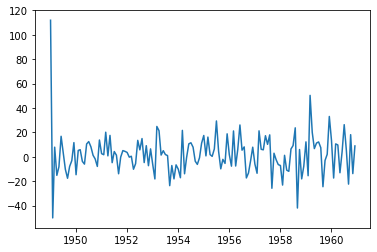

In [36]:
residuos = pd.DataFrame(arima_fit.resid)
plt.plot(residuos)

In [37]:
t_resid = adfuller(residuos)
t_resid

(-3.6530915701276054,
 0.004823488201052157,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 1020.0343451520044)

O gráfico de resíduos não apresenta uma tendência e nem uma sazonalidade aparente. E pelo teste de Dick-Fuller, o valor p é menor que 0,05, portanto indica resíduos estacionários.

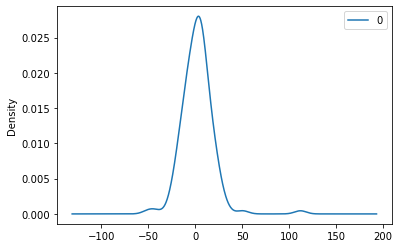

                0
count  144.000000
mean     2.257391
std     16.781007
min    -50.018933
25%     -7.115606
50%      1.911043
75%     10.359304
max    112.000000


In [38]:
residuos.plot(kind='kde')
plt.show()
print(residuos.describe())

O gráfico dos resíduos tem uma distribuição normal.

In [39]:
#pip install pmdarima --user

In [40]:
from pmdarima.arima import auto_arima

start_p e start_q: inicio do p e q

max_p e max_q: maxímo de interações de p e q

m: grau da sazonalidade (ex 12 meses)

seazonal: se é sazonal ou não

d: diferenciação

In [44]:
stepwise_model = auto_arima(data, start_p=1, start_q=1,max_p=12, max_q=16, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
                            suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1022.896, Time=0.14 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.00 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.15 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.11 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.24 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.09 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.19 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.38 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.19 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1020.425, Time=0.08 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=1.18 sec
 ARIMA(0,1,1)(1,1,1)[12]     

In [45]:
print(stepwise_model.aic())

1019.1780567487502


O auto_arima faz uma iterações de acordo com os parâmetros que foram definidos e indica qual o melhor modelo considerando o menor valor de AIC.

Agora vamos fazer a previsão dos dados utilizando o modelo ARIMA. Para isso iremos separar entre dados de treino e dados de teste

In [69]:
train = data.loc['1948-01-01':'1959-12-01']
test = data.loc['1960-01-01':]

In [70]:
stepwise_model.fit(train)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [77]:
previsto = stepwise_model.predict(n_periods=12)

In [78]:
previsto = pd.DataFrame(previsto,index = test.index,columns=["#Passengers"])

<AxesSubplot:xlabel='Month'>

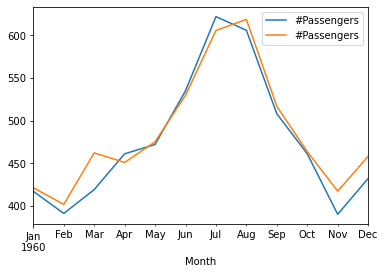

In [79]:
pd.concat([test,previsto],axis=1).plot()

Temos que os dados da previsao e os reais estão bem próximos, com erros provavelmente pequenos.

<AxesSubplot:xlabel='Month'>

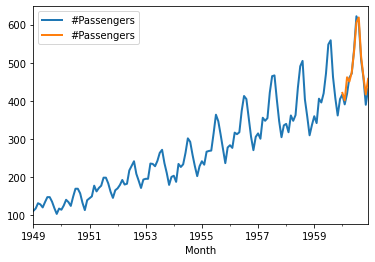

In [80]:
pd.concat([data,previsto],axis=1).plot(linewidth=2)

In [85]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [83]:
mae = mean_absolute_error(test, previsto)
mae

14.163114221739377

In [84]:
mse = mean_squared_error(test, previsto)
mse

337.8529884860359

In [88]:
df_comp = pd.concat([test,previsto],axis=1)
df_comp.corr()

,#Passengers,#Passengers
#Passengers,1.000000,0.979409
#Passengers,0.979409,1.000000


Realizando algumas validações de erros e verificando a correlação dos dados de teste com o previsto podemos verificar que o modelo ARIMA é robusto e consegue prever as séries com tendência e sazonalidade de maneira adequada.